In [11]:
import numpy as np

from engine import RMG, AdvRw
from agent import RandomAgent, IndQLearningAgent, FPLearningAgent, FPQwForgetAgent, Level2QAgent, Level2QAgent_fixed

In [12]:
A = np.array([[[1,2],[3,4]]])


print(A[0,:,:])
print(A.shape)
print(np.dot(A[0,:,:], np.array([0.3,0.7])))

print(np.tensordot(A, np.array([0.3,0.7]), axes=([1],[0])))

[[1 2]
 [3 4]]
(1, 2, 2)
[1.7 3.7]
[[2.4 3.4]]


In [ ]:
possible_actions = [0, 1]  # Target A or B
gamma = 0.8

rw_agents = []
agents = [IndQLearningAgent, FPQwForgetAgent, Level2QAgent, Level2QAgent_fixed]


for agent in agents:
    
    print('Beginning experiments with agent ', agent.__name__)

    N_EXP = 20

    r0ss = []

    smooth = 100

    for n in range(N_EXP):
        batch_size = 1
        max_steps = 1

        mode = 'adversary'
        env = AdvRw(mode, p=0.6)  # p is only used in neutral mode
        
        env.reset()

        p = agent(possible_actions, enemy_action_space=possible_actions, n_states=1, learning_rate=0.1, epsilon=0.1, gamma=gamma)

        # Stateless interactions (agents do not have memory)
        s = 0

        n_iter = 5000 + smooth # because of the smoothening in the graphics

        r0s = []
        r1s = []

        for i in range(n_iter):

            # A full episode:
            done = False

            while not done:

                # Agents decide
                a0 = p.act(obs=s)

                a1 = env.act()
                
                # World changes
                _, (r0, _), done, _ = env.step(a0,a1)

                # # Agents learn
                # if r0 > 0: # p was correct
                #     a1 = a0
                # else:
                #     a1 = 1 - a0
    
                #r1 = -r0
                r1 = float(r0 < 0) 
                #r1 = float(r0 < 0) - 1
                #r1 = float(r0 < 0)*0.05
                #r1 = float(r0 < 0)*2 - 1
                p.update(s, (a0, a1), (r0, r1) , s )

                #s = new_s  #stateless!

                r0s.append(r0)

            env.reset()

        r0ss.append(r0s)
        
    rw_agents.append(r0ss)

Beginning experiments with agent  IndQLearningAgent
Beginning experiments with agent  FPQwForgetAgent
Beginning experiments with agent  Level2QAgent


In [4]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

We report moving avearage of rewards, since it's common in RL taks

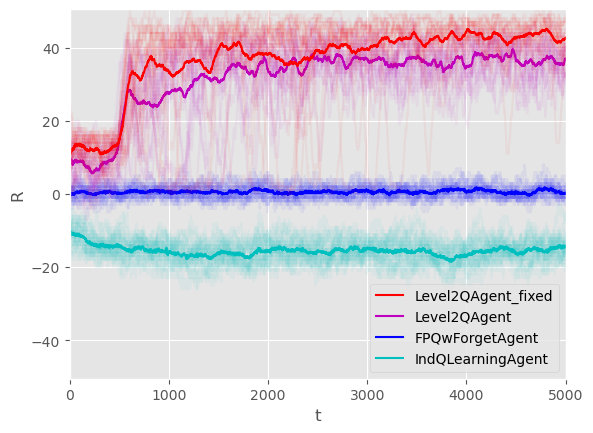

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# We set a fancy theme
plt.style.use('ggplot')

colors = 'cbmr'
plt.axis([0, max_steps*n_iter - smooth, -50.5, 50.5])
for j,a in enumerate(agents):
    r0ss = rw_agents[j]
    for i in range(N_EXP):
        plt.plot(moving_average(r0ss[i], 100), colors[j], alpha=0.05)

    plt.plot(moving_average(np.asarray(r0ss).mean(axis=0), 100), colors[j], alpha=1)

plt.xlabel('t')
plt.ylabel('R')

from matplotlib.lines import Line2D
cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color=colors[::-1][i]) for i,_ in enumerate(agents)]

plt.legend(custom_lines,[a.__name__ for a in reversed(agents)], loc=4)

plt.savefig('img/4C_08_binary' + mode + '.png')

For the adversary case (no forget):

In [6]:
def calculate_DM_statistics(rw_agents, agent_index):
    # Convert the selected agent's rewards to a NumPy array
    rewards = np.asarray(rw_agents[agent_index])
    
    # Calculate cumulative sum along axis 1
    cumulative_rewards = rewards.cumsum(axis=1)
    
    # Mean of cumulative rewards for all steps, across all experiments
    mean_cumulative_rewards_all_steps = cumulative_rewards.mean(axis=0).mean()
    formatted_mean_cumulative_rewards_all_steps = f"{mean_cumulative_rewards_all_steps:,.2f}".replace(",", " ")
    
    # Mean of cumulative rewards for last step, across all experiments
    mean_cumulative_rewards_last_step = cumulative_rewards[:,-1].mean()
    formatted_mean_cumulative_rewards_last_step = f"{mean_cumulative_rewards_last_step:,.2f}".replace(",", " ")
    
    # Mean variance of cumulative rewards for all steps, across all experiments
    mean_variance_all_steps = cumulative_rewards.var(axis=0).mean()
    formatted_mean_variance_all_steps = f"{mean_variance_all_steps:,.2f}".replace(",", " ")
    
    # Mean variance of cumulative rewards only last step, across all experiments
    mean_variance_last_step = cumulative_rewards[:, -1].var(axis=0)
    formatted_mean_variance_last_step = f"{mean_variance_last_step:,.2f}".replace(",", " ")
    
    # Cumulative rewards at the last step
    cumulative_rewards_last_step = cumulative_rewards[:, -1]
    
    # Mean of rewards for all steps, across all experiments
    mean_rewards_all_steps = rewards.mean(axis=0).mean()
    formatted_mean_rewards_all_steps = f"{mean_rewards_all_steps:,.2f}".replace(",", " ")
    
    # Mean variance of rewards for all steps, across all experiments
    mean_variance_rewards_all_steps = rewards.var(axis=0).mean()
    formatted_mean_variance_rewards_all_steps = f"{mean_variance_rewards_all_steps:,.2f}".replace(",", " ")
    
    return {
        "mean_cumulative_rewards_all_steps": formatted_mean_cumulative_rewards_all_steps,
        "mean_cumulative_rewards_last_step": formatted_mean_cumulative_rewards_last_step,
        "mean_variance_all_steps": formatted_mean_variance_all_steps,
        "mean_variance_last_step": formatted_mean_variance_last_step,
        "cumulative_rewards_last_step": cumulative_rewards_last_step,
        "mean_rewards_all_steps": formatted_mean_rewards_all_steps,
        "mean_variance_rewards_all_steps": formatted_mean_variance_rewards_all_steps
    }
    

In [7]:
statistics = calculate_DM_statistics(rw_agents,agent_index=-1)

print("Mean cumulative reward for all steps:", statistics["mean_cumulative_rewards_all_steps"])
print("Mean cumulative reward for last step:", statistics["mean_cumulative_rewards_last_step"])
print("Mean variance of cumulative rewards for all steps:", statistics["mean_variance_all_steps"])
print("Mean variance of cumulative rewards only last step:", statistics["mean_variance_last_step"])
print("Cumulative rewards at the last step:", statistics["cumulative_rewards_last_step"])
print("Mean rewards for all steps:", statistics["mean_rewards_all_steps"])
print("Mean variance of rewards for all steps:", statistics["mean_variance_rewards_all_steps"])


Mean cumulative reward for all steps: 81 862.02
Mean cumulative reward for last step: 185 325.00
Mean variance of cumulative rewards for all steps: 41 542 459.73
Mean variance of cumulative rewards only last step: 38 351 875.00
Cumulative rewards at the last step: [182300 185000 194300 178900 178800 192300 189500 195600 172800 191200
 186100 181900 177300 194800 180700 183400 188700 188000 181100 183800]
Mean rewards for all steps: 36.34
Mean variance of rewards for all steps: 1 023.84


In [8]:
statistics = calculate_DM_statistics(rw_agents,agent_index=-2)

print("Mean cumulative reward for all steps:", statistics["mean_cumulative_rewards_all_steps"])
print("Mean cumulative reward for last step:", statistics["mean_cumulative_rewards_last_step"])
print("Mean variance of cumulative rewards for all steps:", statistics["mean_variance_all_steps"])
print("Mean variance of cumulative rewards only last step:", statistics["mean_variance_last_step"])
print("Cumulative rewards at the last step:", statistics["cumulative_rewards_last_step"])
print("Mean rewards for all steps:", statistics["mean_rewards_all_steps"])
print("Mean variance of rewards for all steps:", statistics["mean_variance_rewards_all_steps"])

Mean cumulative reward for all steps: 69 834.27
Mean cumulative reward for last step: 159 450.00
Mean variance of cumulative rewards for all steps: 21 635 607.08
Mean variance of cumulative rewards only last step: 28 938 500.00
Cumulative rewards at the last step: [160100 159800 165300 154700 150600 164600 159400 159500 163000 168100
 144700 155900 157600 163500 158100 160700 159400 161000 155800 167200]
Mean rewards for all steps: 31.26
Mean variance of rewards for all steps: 1 362.25


In [9]:
statistics = calculate_DM_statistics(rw_agents,agent_index=-3)

print("Mean cumulative reward for all steps:", statistics["mean_cumulative_rewards_all_steps"])
print("Mean cumulative reward for last step:", statistics["mean_cumulative_rewards_last_step"])
print("Mean variance of cumulative rewards for all steps:", statistics["mean_variance_all_steps"])
print("Mean variance of cumulative rewards only last step:", statistics["mean_variance_last_step"])
print("Cumulative rewards at the last step:", statistics["cumulative_rewards_last_step"])
print("Mean rewards for all steps:", statistics["mean_rewards_all_steps"])
print("Mean variance of rewards for all steps:", statistics["mean_variance_rewards_all_steps"])

Mean cumulative reward for all steps: 1 327.29
Mean cumulative reward for last step: 2 850.00
Mean variance of cumulative rewards for all steps: 767 078.28
Mean variance of cumulative rewards only last step: 1 011 500.00
Cumulative rewards at the last step: [2800 3100 4900 1700 1800 3500 2100 3700  900 3200 3200 3300 3500 2300
 1900 1700 3100 4900 2300 3100]
Mean rewards for all steps: 0.56
Mean variance of rewards for all steps: 2 378.55


In [10]:
statistics = calculate_DM_statistics(rw_agents,agent_index=-4)

print("Mean cumulative reward for all steps:", statistics["mean_cumulative_rewards_all_steps"])
print("Mean cumulative reward for last step:", statistics["mean_cumulative_rewards_last_step"])
print("Mean variance of cumulative rewards for all steps:", statistics["mean_variance_all_steps"])
print("Mean variance of cumulative rewards only last step:", statistics["mean_variance_last_step"])
print("Cumulative rewards at the last step:", statistics["cumulative_rewards_last_step"])
print("Mean rewards for all steps:", statistics["mean_rewards_all_steps"])
print("Mean variance of rewards for all steps:", statistics["mean_variance_rewards_all_steps"])

Mean cumulative reward for all steps: -38 825.31
Mean cumulative reward for last step: -78 855.00
Mean variance of cumulative rewards for all steps: 8 408 340.21
Mean variance of cumulative rewards only last step: 20 316 475.00
Cumulative rewards at the last step: [-81300 -77400 -79900 -67800 -67200 -84200 -76200 -81200 -84000 -77600
 -80900 -81000 -76500 -82600 -84600 -77100 -79600 -79500 -80700 -77800]
Mean rewards for all steps: -15.46
Mean variance of rewards for all steps: 2 146.08
